supp figure 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = Path('../dataset/channel_inf.txt')
EXCLUDED_CHANNELS = {18, 31, 32}  
NORMALIZATION_SCALE = 6           

def load_electrode_data(file_path: Path) -> tuple[dict, dict]:
    """加载电极位置数据并进行初步处理
    
    Args:
        file_path: 电极数据文件路径
        
    Returns:
        ch_pos: 电极位置字典 {电极名: [x,y,z]}
        ch_name: 电极名称映射 {编号: 名称}
    """
    ch_pos, ch_name = {}, {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f.readlines()[1:]:  
            parts = line.strip().split('\t')
            channel_num = int(parts[0])
            if channel_num in EXCLUDED_CHANNELS:
                continue
                
            coordinates = [float(x) if x != 'NaN' else 0.0 for x in parts[4:6]] + [0.0]
            ch_pos[f"EEG {channel_num}"] = coordinates
            ch_name[len(ch_name)+1] = f"EEG {channel_num}" 
            
    return ch_pos, ch_name

def normalize_coordinates(raw_pos: dict) -> dict:
    """对电极坐标进行归一化处理
    
    Args:
        raw_pos: 原始坐标字典
        
    Returns:
        归一化后的坐标字典
    """
    positions = np.array(list(raw_pos.values()))
    
    min_vals = positions.min(axis=0)
    max_vals = positions.max(axis=0)
    norm_pos = (positions - min_vals) / (max_vals - min_vals) - 0.5
    
    norm_pos[:, [0, 1]] = norm_pos[:, [1, 0]] 
    norm_pos = [
        [0 if np.isnan(coord) else coord for coord in norm_ch_pos] 
        for norm_ch_pos in norm_pos
    ]
                
    return {ch: [(coord / NORMALIZATION_SCALE) for coord in pos] 
        for ch, pos in zip(raw_pos.keys(), norm_pos)}

def configure_plot_style():
    plt.rcParams.update({
        'font.family': 'Arial',        
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.linewidth': 1.5,
        'xtick.major.width': 1.5,
        'ytick.major.width': 1.5,
        'savefig.dpi': 300,            
        'savefig.transparent': True    
    })

supp figure 3A

/tmp/ipykernel_2466261/354101352.py:46: RuntimeWarning: invalid value encountered in divide
  norm_pos = (positions - min_vals) / (max_vals - min_vals) - 0.5


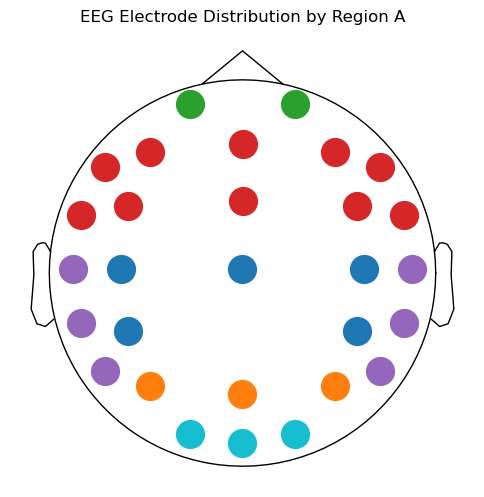

In [ ]:
import mne

COLOR_SCHEME_1 = {      
    'All': '#7f7f7f',            
    'Forehead': '#2ca02c',   
    'Frontal': '#d62728',    
    'Center': '#1f77b4',     
    'Temporal': '#9467bd',   
    'Parietal': '#ff7f0e',   
    'Occipital': '#17becf'   
}

REGION_DEFINITION_1 = {
    'Forehead': list(range(0, 2)),       
    'Frontal': list(range(2, 12)),       
    'Center': [12, 13, 14, 17, 18],      
    'Temporal': [15, 16, 19, 20, 24, 25],
    'Parietal': [21, 22, 23],            
    'Occipital': [26, 27, 28]            
}

ch_pos, ch_name = load_electrode_data(DATA_PATH)
normed_ch_pos = normalize_coordinates(ch_pos)
processed_ch_pos = {f"EEG {i+1}": pos for i, pos in enumerate(normed_ch_pos.values())}

processed_ch_color = {}
for region, channels in REGION_DEFINITION_1.items():
    for channel in channels:
        channel_name = f"EEG {channel+1}"
        processed_ch_color[channel_name] = COLOR_SCHEME_1[region]

montage = mne.channels.make_dig_montage(ch_pos=processed_ch_pos, coord_frame='head')

ch_names = list(processed_ch_pos.keys())
info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types='eeg')
info.set_montage(montage)

fig, ax = plt.subplots(figsize=(6,6))
head_circle = plt.Circle((0, 0), 0.5, color='k', fill=False)
ax.add_artist(head_circle)
mne.viz.plot_montage(montage, show_names=None, show=False, axes=ax)

for ch_name, color in processed_ch_color.items():
    pos = processed_ch_pos[ch_name]
    ax.plot(pos[0], pos[1], 'o', color=color, markersize=20)

plt.title('EEG Electrode Distribution by Region A')
plt.savefig('figure/supp_3A.tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.show()

supp figure 3B

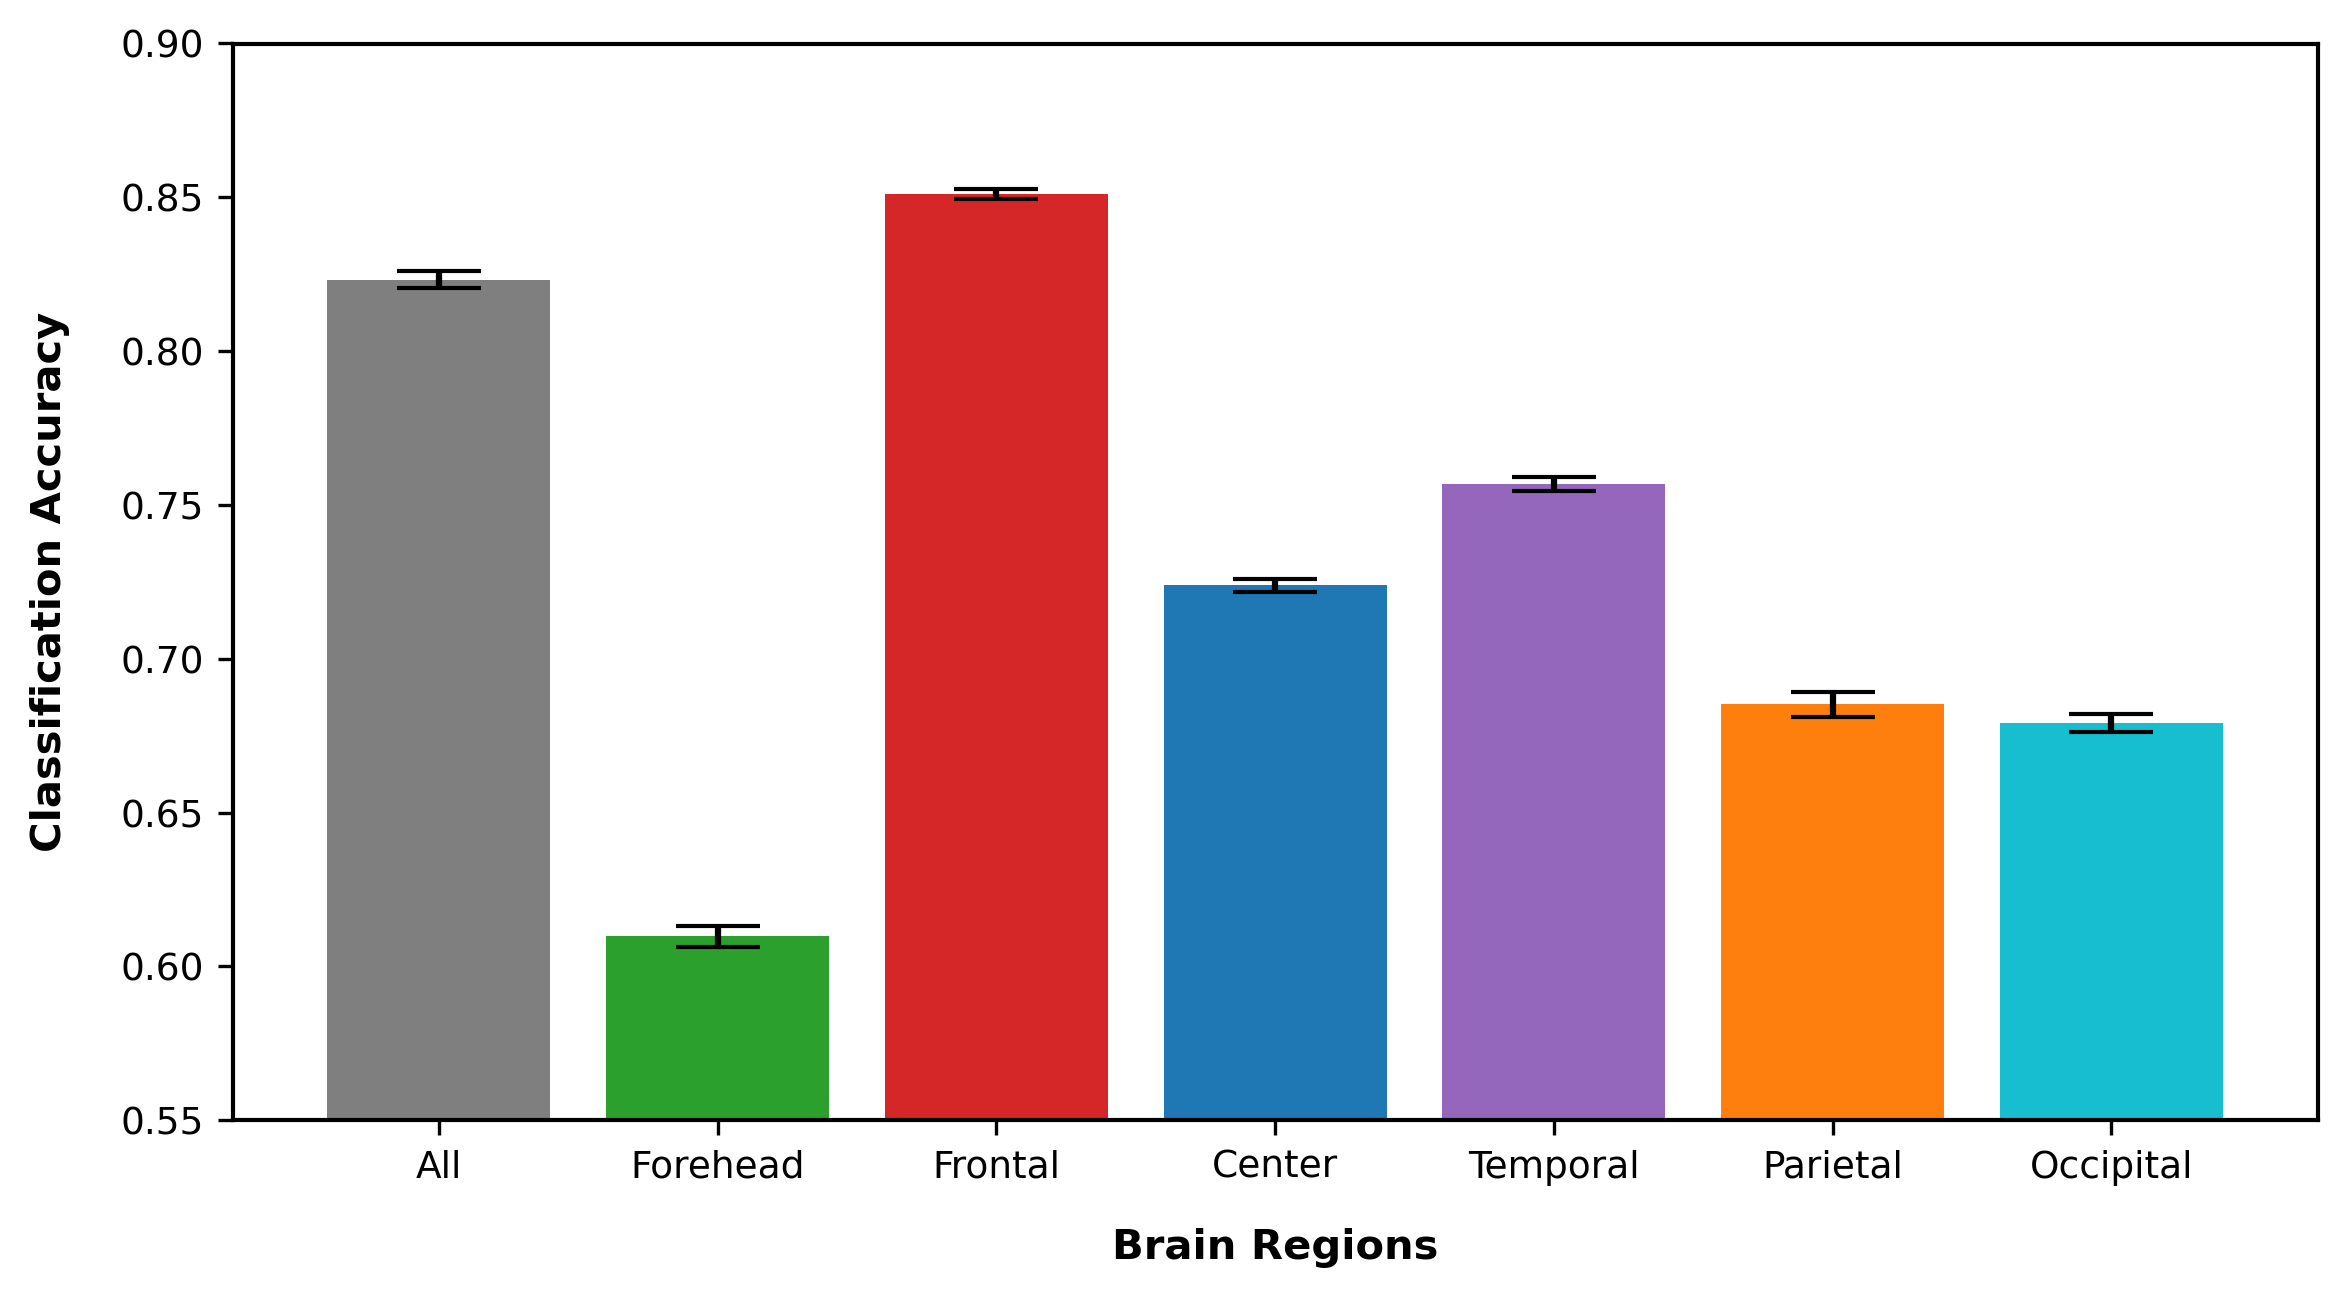

In [ ]:
import pickle

load_file = '../dataset/TBF_regions_1_acc.pkl'
with open(load_file, 'rb') as f:
    TBF_region_results = pickle.load(f)

regions = list(TBF_region_results.keys())
accuracies_means = [np.mean(TBF_region_results[region]) for region in regions] 
accuracies_stds = [np.std(TBF_region_results[region]) for region in regions]

plt.rcParams.update({
    'font.family': 'DejaVu Sans', 
    'font.size': 9,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'axes.linewidth': 1.0,
    'lines.linewidth': 1.5,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})

plt.figure(figsize=(8, 4.5))  

bar_colors = []
for _, color in COLOR_SCHEME_1.items():
    bar_colors.append(color)        

bars = plt.bar(
    regions, 
    accuracies_means,
    color=bar_colors,
    yerr=accuracies_stds,
    capsize=10       
)

plt.ylim(0.55, 0.9)
plt.ylabel('Classification Accuracy', fontweight='bold', labelpad=12)  
plt.xlabel('Brain Regions', fontweight='bold', labelpad=10)

plt.tight_layout(pad=1.5)
plt.savefig('figure/supp_3B.tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})  
plt.show()

supp figure 3C

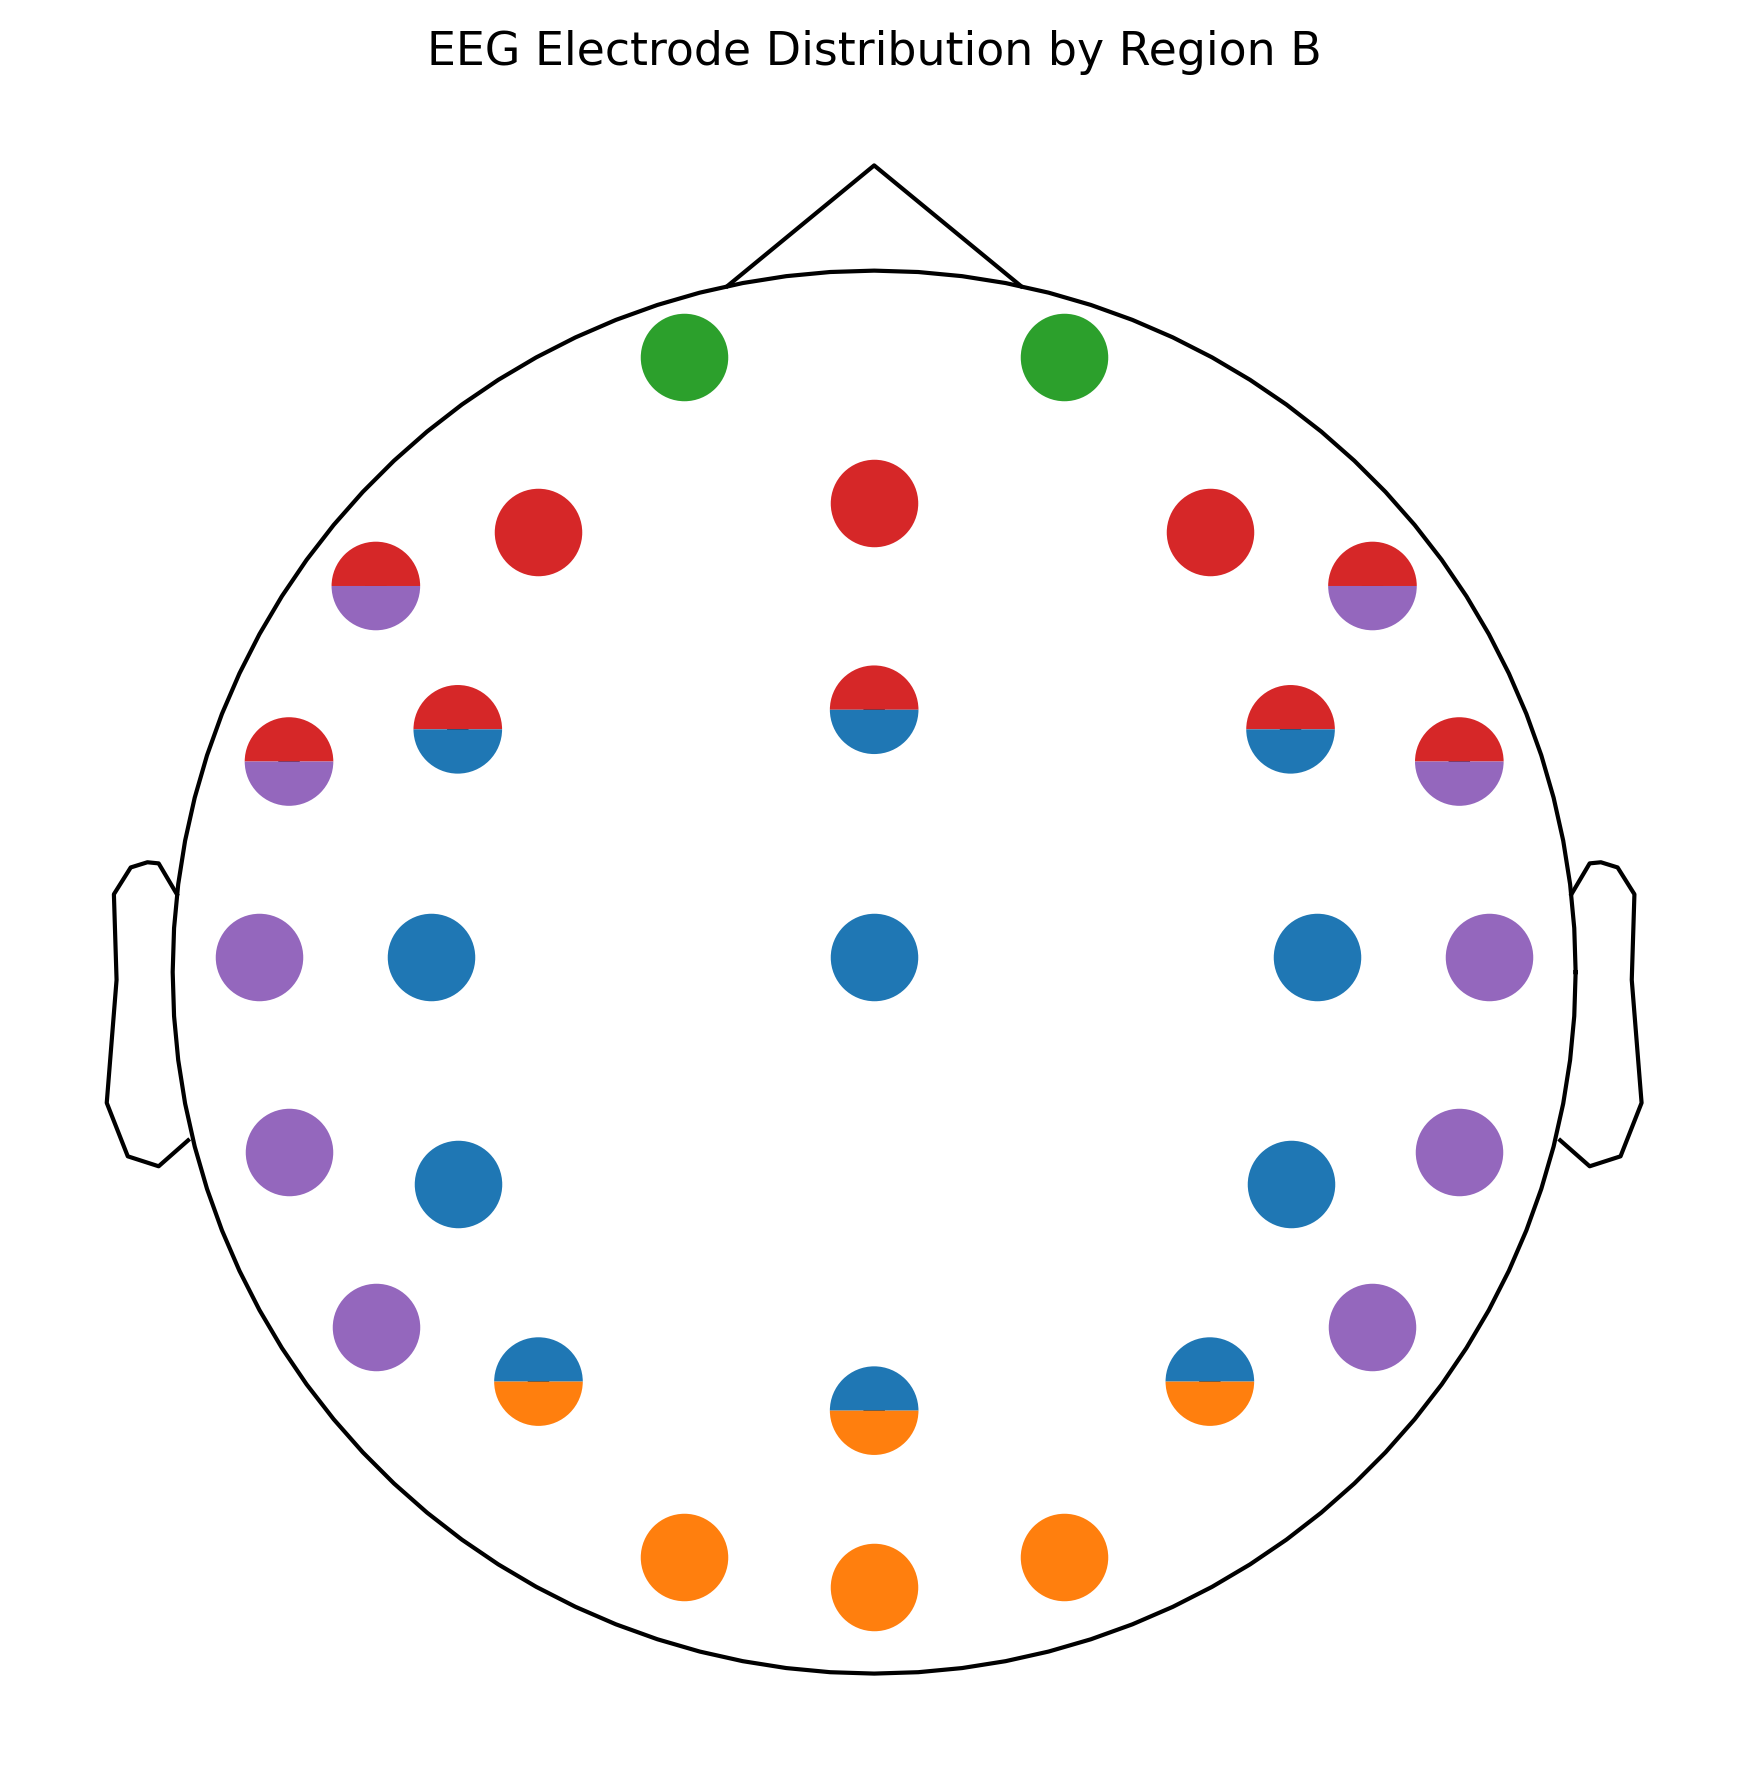

In [ ]:
import matplotlib.patches as patches

COLOR_SCHEME_2 = {                  
    'All': '#7F7F7F',
    'Forehead': '#2ca02c',   
    'Frontal': '#d62728',    
    'Center': '#1f77b4',     
    'Temporal': '#9467bd',   
    'Parietal': '#ff7f0e',   
}

REGION_DEFINITION_2 = {
    'Forehead': list(range(0, 2)), 
    'Frontal': list(range(2, 12)), 
    'Center': [7, 8, 9, 12, 13, 14, 17, 18, 21, 22, 23], 
    'Temporal': [5, 6, 10, 11, 15, 16, 19, 20, 24, 25],
    'Parietal': list(range(21,24)) + list(range(26, 29))
}

processed_ch_color = {}
overlap_channels = {}
for region, channels in REGION_DEFINITION_2.items():
    for channel in channels:
        channel_name = f"EEG {channel+1}"
        if channel_name in processed_ch_color:
            if channel_name not in overlap_channels:
                overlap_channels[channel_name] = [processed_ch_color[channel_name]]
            overlap_channels[channel_name].append(COLOR_SCHEME_2[region])
        else:
            processed_ch_color[channel_name] = COLOR_SCHEME_2[region]
for ch_name, assigned_colors in overlap_channels.items():
    processed_ch_color[ch_name] = assigned_colors

montage = mne.channels.make_dig_montage(ch_pos=processed_ch_pos, coord_frame='head')

fig, ax = plt.subplots(figsize=(6,6))
head_circle = plt.Circle((0, 0), 0.5, color='k', fill=False)
ax.add_artist(head_circle)
mne.viz.plot_montage(montage, show_names=None, show=False, axes=ax)

for ch_name, pos in processed_ch_pos.items():
    if ch_name in overlap_channels:
        channel_colors = overlap_channels[ch_name]
        num_colors = len(channel_colors)
        angles = np.linspace(0, 360, num_colors + 1)  
        for i in range(num_colors):
            theta1 = angles[i]
            theta2 = angles[i + 1]
            wedge = patches.Wedge(
                (pos[0], pos[1]), 0.006, theta1, theta2, facecolor=channel_colors[i], edgecolor='none'
            )
            ax.add_patch(wedge)
    else:
        ax.plot(pos[0], pos[1], 'o', color=processed_ch_color[ch_name], markersize=20)

plt.title('EEG Electrode Distribution by Region B')
plt.savefig('figure/supp_3C.tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.show()

supp figure 3D

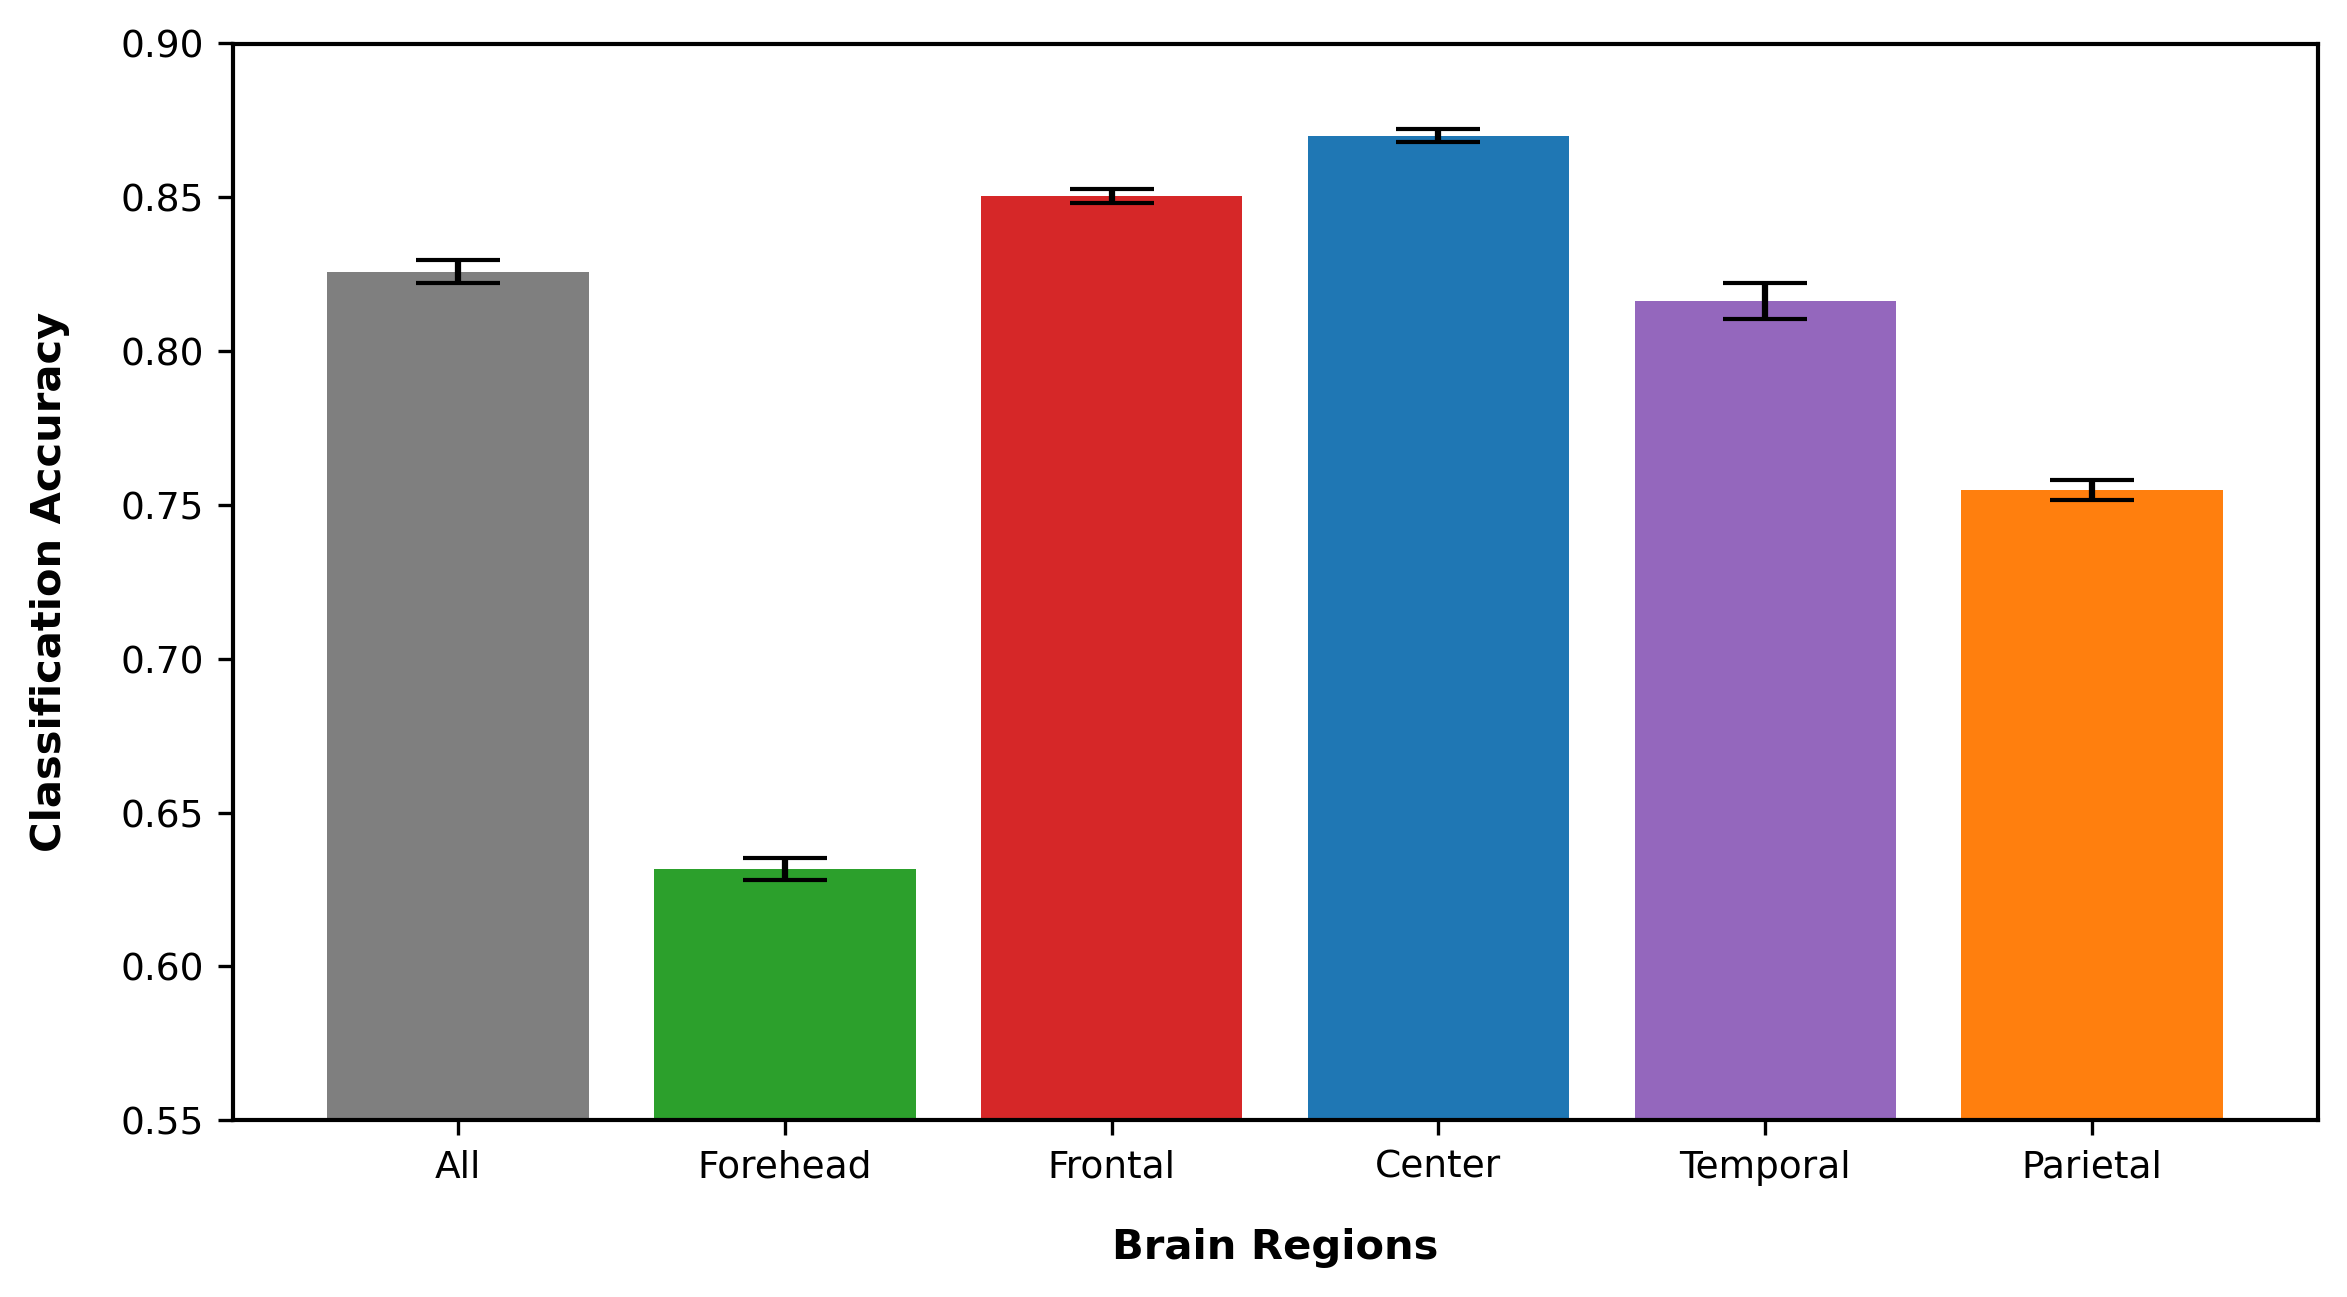

In [ ]:
load_file = '../dataset/TBF_regions_2_acc.pkl'
with open(load_file, 'rb') as f:
    TBF_region_results = pickle.load(f)

regions = list(TBF_region_results.keys())
accuracies_means = [np.mean(TBF_region_results[region]) for region in regions] 
accuracies_stds = [np.std(TBF_region_results[region]) for region in regions]

plt.rcParams.update({
    'font.family': 'DejaVu Sans',  
    'font.size': 9,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'axes.linewidth': 1.0,
    'lines.linewidth': 1.5,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})

plt.figure(figsize=(8, 4.5))  

bar_colors = []
for _, color in COLOR_SCHEME_2.items():
    bar_colors.append(color)        

bars = plt.bar(
    regions, 
    accuracies_means,
    color=bar_colors,
    yerr=accuracies_stds,
    capsize=10       
)

plt.ylim(0.55, 0.9)
plt.ylabel('Classification Accuracy', fontweight='bold', labelpad=12)  
plt.xlabel('Brain Regions', fontweight='bold', labelpad=10)

plt.tight_layout(pad=1.5)
plt.savefig('figure/supp_3D.tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})  
plt.show()